In [1]:
%matplotlib inline
#將全部會用掉的套件都import在這裡
#資料前處理
import numpy as np
import pandas as pd
import operator 

#K - fold 
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error,make_scorer
#sklearn.metrics表示模型評估
from sklearn.model_selection import GridSearchCV, KFold,StratifiedKFold, cross_val_score, learning_curve #網格搜詢、K次交叉驗證

#高斯
from sklearn.gaussian_process import GaussianProcessRegressor as gpr #高斯回歸模型
from sklearn.gaussian_process.kernels import ConstantKernel,DotProduct, RBF, RationalQuadratic, ExpSineSquared, Matern, Exponentiation
#CustinKernel高斯核函數，DotProduct點積，徑向基函數（RBF）內核，RationalQuadratic內核組件，ExpSineSquared正弦平方內核，Matérn內核
#較小的中期不規則性將由RationalQuadratic內核組件來解釋，RationalQuadratic內核組件的長度尺度和alpha參數決定長度尺度的擴散性
#ExpSipneSquared正弦平方內核，該ExpSineSquared內核允許造型週期函數
#Matérn內核，該Matern內核是一個固定的內核和的推廣RBF內核。它有一個額外的參數來控制所得到的函數的平滑度

#畫圖
import matplotlib.pyplot as plt
import seaborn as sns 

import matplotlib as mpl
import warnings
import sklearn
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn import metrics
from bayes_opt import BayesianOptimization
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)
from sklearn.pipeline import make_pipeline
import random

In [2]:
from sklearn import mixture

### 求預測誤差的MAPE公式

In [3]:
def my_custom_score_func(ture_value, prediction_value):
    return np.mean(np.abs((prediction_value- ture_value))/ture_value)*100

In [4]:
#訓練數據集
Train = pd.read_csv('./data/trainingData81.csv')
#測試集資料讀取
Test = pd.read_csv('./data/Testingdata.csv')
print(Train.head(10))

      d   x1   x2   x3   x4     TI_03     TI_15    vel_03    vel_15
0   1.2  0.1  0.1  0.1  0.1  0.085802  0.181751  0.768415  0.744848
1   2.0  0.1  0.1  0.1  0.1  0.077405  0.167946  0.780051  0.767193
2   3.0  0.1  0.1  0.1  0.1  0.071819  0.159149  0.786930  0.779569
3   4.0  0.1  0.1  0.1  0.1  0.068473  0.154054  0.791024  0.785729
4   5.0  0.1  0.1  0.1  0.1  0.066201  0.150582  0.793827  0.789416
5   6.0  0.1  0.1  0.1  0.1  0.064567  0.147952  0.795809  0.791905
6   7.0  0.1  0.1  0.1  0.1  0.063361  0.145820  0.797222  0.793711
7   8.0  0.1  0.1  0.1  0.1  0.062461  0.144016  0.798223  0.795075
8   9.0  0.1  0.1  0.1  0.1  0.061787  0.142441  0.798918  0.796129
9  10.0  0.1  0.1  0.1  0.1  0.061281  0.141038  0.799385  0.796953


In [5]:
Train.rename(columns = {"x1": "beta_p", 
                      "x2": "beta_d",
                      "x3": "c_eps4",
                      "x4": "c_eps5",
                     }, inplace = True)

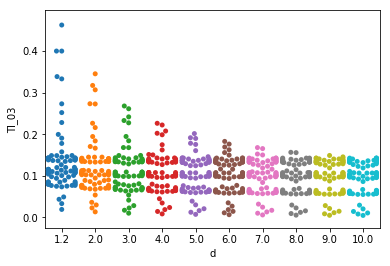

In [6]:
sns.swarmplot(x="d", y="TI_03",data=Train)

In [7]:
exp_data = { 'exp_03_TI'  : [  0.219, 0.168, 0.139, 0.176, 0.197, 0.191, 0.16 , 0.146, 0.129, 0.122  ],
             'exp_15_TI'  : [  0.321, 0.286, 0.217, 0.192, 0.170, 0.170, 0.137, 0.136, 0.134, 0.138  ],
             'exp_03_vel' : [  0.402, 0.403, 0.396, 0.387, 0.402, 0.445, 0.494, 0.548, 0.569, 0.610  ],
             'exp_15_vel' : [  0.400, 0.476, 0.630, 0.690, 0.729, 0.730, 0.742, 0.762, 0.772, 0.763  ]
}
d = [1.2, 2 , 3, 4, 5, 6, 7, 8, 9, 10 ]

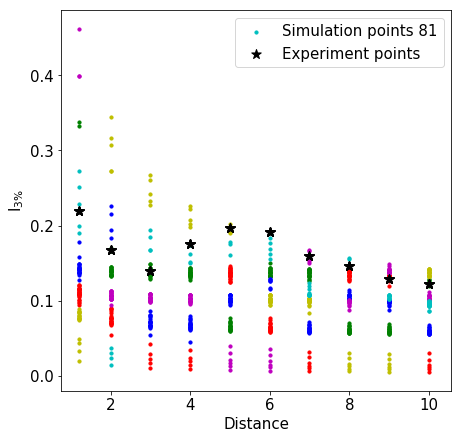

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
fig, ax = plt.subplots(figsize=(7,7))
for index,value in enumerate(d):
    data_set=Train[['d','TI_03']][Train['d'] == value].values
    cluster_num = 6
    kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
    clusters = kmeans.labels_
    centroids = np.array([[value,exp_data['exp_03_TI'][index]]])
    colors = ['r', 'g', 'b', 'y', 'm','c']
    for cluster_index in range(cluster_num) :
        sub_set = np.array([data_set[i] for i in range(len(data_set)) if clusters[i] == cluster_index])
        plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
        plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k')
plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index],label='Simulation points 81')
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k',label='Experiment points')
plt.legend(loc='best',fontsize=15)
plt.xlabel('Distance', fontsize=15)
plt.ylabel(r'I$_{3\%}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./TI03.png',format='png')
plt.show()

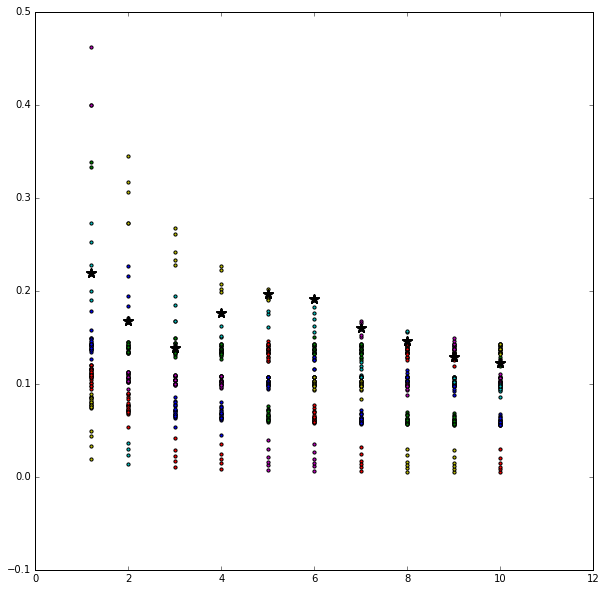

In [53]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
fig, ax = plt.subplots(figsize=(10,10))
for index,value in enumerate(d):
    data_set=Train[['d','TI_03']][Train['d'] == value].values
    cluster_num = 6
    kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
    clusters = kmeans.labels_
    centroids = np.array([[value,exp_data['exp_03_TI'][index]]])
    colors = ['r', 'g', 'b', 'y', 'm','c']
    for cluster_index in range(cluster_num) :
        sub_set = np.array([data_set[i] for i in range(len(data_set)) if clusters[i] == cluster_index])
        plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
        plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k')
#plt.savefig('./TI03聚类.png',format='png')
plt.show()

In [9]:
data_set=Train[['d','TI_03']][Train['d'] == 1.2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df1 = pd.DataFrame(data_set[[ x==5 for x in kmeans.labels_]])

In [10]:
data_set=Train[['d','TI_03']][Train['d'] == 2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df2 = pd.DataFrame(data_set[[ x==1 for x in kmeans.labels_]])
#df2

In [11]:
data_set=Train[['d','TI_03']][Train['d'] == 3].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df3 = pd.DataFrame(data_set[[ x==1 for x in kmeans.labels_]])
#df3

In [12]:
data_set=Train[['d','TI_03']][Train['d'] == 4].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df4 = pd.DataFrame(data_set[[ x==5 for x in kmeans.labels_]])
#df4

In [13]:
data_set=Train[['d','TI_03']][Train['d'] == 5].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df5 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
df5

,0,1
0,5.0,0.191531
1,5.0,0.201509
2,5.0,0.189861


In [14]:
data_set=Train[['d','TI_03']][Train['d'] == 6].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df6 = pd.DataFrame(data_set[[ x==5 for x in kmeans.labels_]])
df6

,0,1
0,6.0,0.155871
1,6.0,0.162617
2,6.0,0.169336
3,6.0,0.182764
4,6.0,0.176298


In [15]:
data_set=Train[['d','TI_03']][Train['d'] == 7].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df7 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df7

,0,1
0,7.0,0.150142
1,7.0,0.152399
2,7.0,0.167902
3,7.0,0.165477


In [16]:
data_set=Train[['d','TI_03']][Train['d'] == 8].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df8 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
df8

,0,1
0,8.0,0.128805
1,8.0,0.139868
2,8.0,0.134066
3,8.0,0.140644
4,8.0,0.140560
5,8.0,0.140478
6,8.0,0.142650
7,8.0,0.142650
8,8.0,0.142650
9,8.0,0.138985


In [17]:
data_set=Train[['d','TI_03']][Train['d'] == 9].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df9 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
df9

,0,1
0,9.0,0.118990
1,9.0,0.131215
2,9.0,0.128040
3,9.0,0.128063
4,9.0,0.127362
5,9.0,0.134687
6,9.0,0.133275
7,9.0,0.133555
8,9.0,0.132722
9,9.0,0.128988


In [18]:
data_set=Train[['d','TI_03']][Train['d'] == 10].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df10 = pd.DataFrame(data_set[[ x==1 for x in kmeans.labels_]])
df10

,0,1
0,10.0,0.123802
1,10.0,0.122831
2,10.0,0.118976
3,10.0,0.127182
4,10.0,0.129002
5,10.0,0.125623


In [19]:
data_TI03 = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 ], ignore_index=True)
Train_cluster_TI03 = Train[Train['TI_03'].isin(data_TI03[1].values)].reset_index()
Train_cluster_TI03

,index,d,beta_p,beta_d,c_eps4,c_eps5,TI_03,TI_15,vel_03,vel_15
0,60,1.2,0.10,0.10,1.00,0.10,0.251953,0.189052,0.531672,0.734357
1,63,4.0,0.10,0.10,1.00,0.10,0.162229,0.155305,0.657187,0.783726
2,70,1.2,0.10,0.10,1.00,2.05,0.228103,0.187333,0.592851,0.736880
3,73,4.0,0.10,0.10,1.00,2.05,0.150299,0.155016,0.702466,0.784223
4,80,1.2,0.10,0.10,1.00,4.00,0.199546,0.185970,0.641425,0.738858
5,81,2.0,0.10,0.10,1.00,4.00,0.170509,0.170330,0.686566,0.763898
6,82,3.0,0.10,0.10,1.00,4.00,0.148815,0.160437,0.715584,0.777772
7,120,1.2,0.10,2.05,0.55,0.10,0.190487,0.178998,0.477738,0.716319
8,123,4.0,0.10,2.05,0.55,0.10,0.151300,0.150030,0.590664,0.780759
9,181,2.0,0.10,4.00,0.10,0.10,0.166521,0.158708,0.608522,0.751547


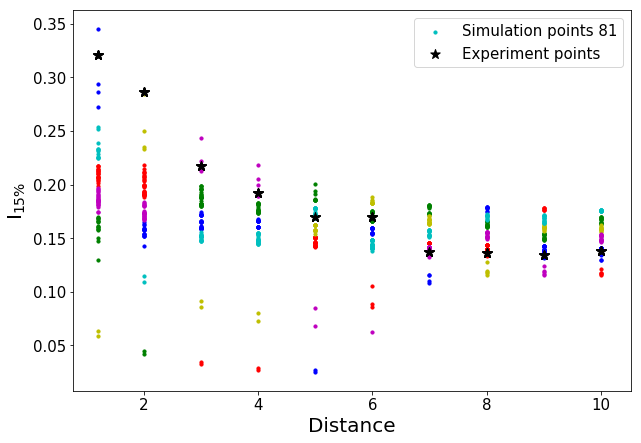

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
fig, ax = plt.subplots(figsize=(10,7))
for index,value in enumerate(d):
    data_set=Train[['d','TI_15']][Train['d'] == value].values
    cluster_num = 6
    kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
    clusters = kmeans.labels_
    centroids = np.array([[value,exp_data['exp_15_TI'][index]]])
    colors = ['r', 'g', 'b', 'y', 'm','c']
    for cluster_index in range(cluster_num) :
        sub_set = np.array([data_set[i] for i in range(len(data_set)) if clusters[i] == cluster_index])
        plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
        plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k')
plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index],label='Simulation points 81')
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k',label='Experiment points')
#plt.savefig('./TI15.png',format='png')
plt.legend(loc='best',fontsize=15)
plt.xlabel('Distance', fontsize=20)
plt.ylabel(r'I$_{15\%}$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('./TI03聚类.png',format='png')
plt.savefig('./TI15.png',format='png')
plt.show()

In [21]:
data_set=Train[['d','TI_15']][Train['d'] == 1.2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df11 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df11

,0,1
0,1.2,0.345609
1,1.2,0.294300
2,1.2,0.272295
3,1.2,0.285949


In [22]:
data_set=Train[['d','TI_15']][Train['d'] == 2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df12 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
df12

,0,1
0,2.0,0.284644
1,2.0,0.249992
2,2.0,0.235558
3,2.0,0.233675


In [23]:
data_set=Train[['d','TI_15']][Train['d'] == 3].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df13 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df13

,0,1
0,3.0,0.243451
1,3.0,0.221657
2,3.0,0.212736


In [24]:
data_set=Train[['d','TI_15']][Train['d'] == 4].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df14 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df14

,0,1
0,4.0,0.189881
1,4.0,0.189842
2,4.0,0.189806
3,4.0,0.191222
4,4.0,0.191082
5,4.0,0.190958
6,4.0,0.218227
7,4.0,0.205105
8,4.0,0.199598


In [25]:
data_set=Train[['d','TI_15']][Train['d'] == 5].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df15 = pd.DataFrame(data_set[[ x==5 for x in kmeans.labels_]])
df15

,0,1
0,5.0,0.169403
1,5.0,0.169374
2,5.0,0.169346
3,5.0,0.170034
4,5.0,0.169947
5,5.0,0.169872
6,5.0,0.174643
7,5.0,0.172806
8,5.0,0.171965
9,5.0,0.177946


In [26]:
data_set=Train[['d','TI_15']][Train['d'] == 6].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df16 = pd.DataFrame(data_set[[ x==1 for x in kmeans.labels_]])
df16

,0,1
0,6.0,0.166261
1,6.0,0.166252
2,6.0,0.166242
3,6.0,0.166493
4,6.0,0.166459
5,6.0,0.166429
6,6.0,0.168537
7,6.0,0.167725
8,6.0,0.167344
9,6.0,0.174856


In [27]:
data_set=Train[['d','TI_15']][Train['d'] == 7].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df17 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df17

,0,1
0,7.0,0.141760
1,7.0,0.141738
2,7.0,0.141675
3,7.0,0.141645
4,7.0,0.141753
5,7.0,0.141689
6,7.0,0.140797
7,7.0,0.141767
8,7.0,0.141704
9,7.0,0.139665


In [28]:
data_set=Train[['d','TI_15']][Train['d'] == 8].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df18 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
df18

,0,1
0,8.0,0.144016
1,8.0,0.144017
2,8.0,0.144017
3,8.0,0.143997
4,8.0,0.144006
5,8.0,0.144011
6,8.0,0.143927
7,8.0,0.143959
8,8.0,0.143980
9,8.0,0.140088


In [29]:
data_set=Train[['d','TI_15']][Train['d'] == 9].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df19 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df19

,0,1
0,9.0,0.142441
1,9.0,0.142455
2,9.0,0.142466
3,9.0,0.142368
4,9.0,0.142394
5,9.0,0.142416
6,9.0,0.142207
7,9.0,0.142273
8,9.0,0.142320
9,9.0,0.138611


In [30]:
data_set=Train[['d','TI_15']][Train['d'] == 10].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df20 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df20

,0,1
0,10.0,0.141038
1,10.0,0.141061
2,10.0,0.141082
3,10.0,0.140918
4,10.0,0.140960
5,10.0,0.140995
6,10.0,0.140682
7,10.0,0.140775
8,10.0,0.140846
9,10.0,0.137279


In [31]:
data_TI15 = pd.concat([df11, df12, df13, df14, df15, df16, df17, df18, df19, df20 ], ignore_index=True)
Train_cluster_TI15 = Train[Train['TI_15'].isin(data_TI15[1].values)].reset_index()
Train_cluster_TI15

,index,d,beta_p,beta_d,c_eps4,c_eps5,TI_03,TI_15,vel_03,vel_15
0,7,8.0,0.1,0.10,0.10,0.10,0.062461,0.144016,0.798223,0.795075
1,8,9.0,0.1,0.10,0.10,0.10,0.061787,0.142441,0.798918,0.796129
2,9,10.0,0.1,0.10,0.10,0.10,0.061281,0.141038,0.799385,0.796953
3,17,8.0,0.1,0.10,0.10,2.05,0.062312,0.144017,0.798290,0.795136
4,18,9.0,0.1,0.10,0.10,2.05,0.061656,0.142455,0.798965,0.796182
5,19,10.0,0.1,0.10,0.10,2.05,0.061165,0.141061,0.799414,0.797001
6,27,8.0,0.1,0.10,0.10,4.00,0.062179,0.144017,0.798349,0.795191
7,28,9.0,0.1,0.10,0.10,4.00,0.061538,0.142466,0.799006,0.796230
8,29,10.0,0.1,0.10,0.10,4.00,0.061061,0.141082,0.799440,0.797043
9,37,8.0,0.1,0.10,0.55,0.10,0.069799,0.143997,0.793737,0.794790


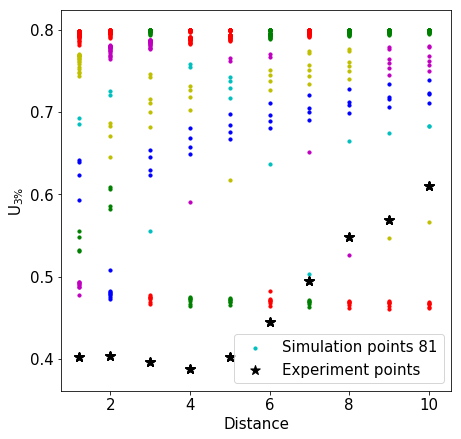

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
fig, ax = plt.subplots(figsize=(7,7))
for index,value in enumerate(d):
    data_set=Train[['d','vel_03']][Train['d'] == value].values
    cluster_num = 6
    kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
    clusters = kmeans.labels_
    centroids = np.array([[value,exp_data['exp_03_vel'][index]]])
    colors = ['r', 'g', 'b', 'y', 'm','c']
    for cluster_index in range(cluster_num) :
        sub_set = np.array([data_set[i] for i in range(len(data_set)) if clusters[i] == cluster_index])
        plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
        plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k')
plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index],label='Simulation points 81')
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k',label='Experiment points')
plt.legend(loc='best',fontsize=15)
plt.xlabel('Distance', fontsize=15)
plt.ylabel(r'U$_{3\%}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('./TI03聚类.png',format='png')
plt.savefig('./U03.png',format='png')
#plt.savefig('./TI03聚类.png',format='png')
plt.show()

In [33]:
data_set=Train[['d','vel_03']][Train['d'] == 1.2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df21 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df21

,0,1
0,1.2,0.477738
1,1.2,0.492946
2,1.2,0.486955
3,1.2,0.493690
4,1.2,0.489799
5,1.2,0.491751
6,1.2,0.487527
7,1.2,0.490747


In [34]:
data_set=Train[['d','vel_03']][Train['d'] == 2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df22 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df22

,0,1
0,2.0,0.507711
1,2.0,0.480902
2,2.0,0.472706
3,2.0,0.482265
4,2.0,0.477680
5,2.0,0.480301
6,2.0,0.475051
7,2.0,0.479163


In [35]:
data_set=Train[['d','vel_03']][Train['d'] == 3].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df23 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
df23

,0,1
0,3.0,0.475506
1,3.0,0.466270
2,3.0,0.477384
3,3.0,0.472439
4,3.0,0.475691
5,3.0,0.469583
6,3.0,0.474442


In [36]:
data_set=Train[['d','vel_03']][Train['d'] == 4].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df24 = pd.DataFrame(data_set[[ x==1 for x in kmeans.labels_]])
df24

,0,1
0,4.0,0.473000
1,4.0,0.464727
2,4.0,0.474998
3,4.0,0.469999
4,4.0,0.473614
5,4.0,0.467010
6,4.0,0.472306


In [37]:
data_set=Train[['d','vel_03']][Train['d'] == 5].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df25 = pd.DataFrame(data_set[[ x==1 for x in kmeans.labels_]])
df25

,0,1
0,5.0,0.471457
1,5.0,0.469282
2,5.0,0.473350
3,5.0,0.468462
4,5.0,0.472139
5,5.0,0.465371
6,5.0,0.470839


In [38]:
data_set=Train[['d','vel_03']][Train['d'] == 6].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df26 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
df26

,0,1
0,6.0,0.470365
1,6.0,0.482904
2,6.0,0.472169
3,6.0,0.467337
4,6.0,0.470997
5,6.0,0.464133
6,6.0,0.469725


In [39]:
data_set=Train[['d','vel_03']][Train['d'] == 7].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df27 = pd.DataFrame(data_set[[ x==5 for x in kmeans.labels_]])
df27

,0,1
0,7.0,0.503377


In [40]:
data_set=Train[['d','vel_03']][Train['d'] == 8].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df28 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df28

,0,1
0,8.0,0.525693


In [41]:
data_set=Train[['d','vel_03']][Train['d'] == 9].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df29 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
df29

,0,1
0,9.0,0.546898


In [42]:
data_set=Train[['d','vel_03']][Train['d'] == 10].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df30 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
df30

,0,1
0,10.0,0.566036


In [43]:
data_vel03 = pd.concat([df21, df22, df23, df24, df25, df26, df27, df28, df29, df30 ], ignore_index=True)
Train_cluster_vel03 = Train[Train['vel_03'].isin(data_vel03[1].values)].reset_index()
Train_cluster_vel03

,index,d,beta_p,beta_d,c_eps4,c_eps5,TI_03,TI_15,vel_03,vel_15
0,120,1.2,0.10,2.05,0.55,0.1,0.190487,0.178998,0.477738,0.716319
1,121,2.0,0.10,2.05,0.55,0.1,0.183936,0.164996,0.507711,0.751802
2,150,1.2,0.10,2.05,1.00,0.1,0.049350,0.191475,0.492946,0.669887
3,151,2.0,0.10,2.05,1.00,0.1,0.036422,0.173529,0.480902,0.723964
4,152,3.0,0.10,2.05,1.00,0.1,0.028513,0.159805,0.475506,0.755967
5,153,4.0,0.10,2.05,1.00,0.1,0.023995,0.151926,0.473000,0.771502
6,154,5.0,0.10,2.05,1.00,0.1,0.021016,0.146929,0.471457,0.780043
7,155,6.0,0.10,2.05,1.00,0.1,0.018877,0.143440,0.470365,0.785211
8,210,1.2,0.10,4.00,0.55,0.1,0.104173,0.174258,0.486955,0.680476
9,211,2.0,0.10,4.00,0.55,0.1,0.090247,0.163115,0.472706,0.733851


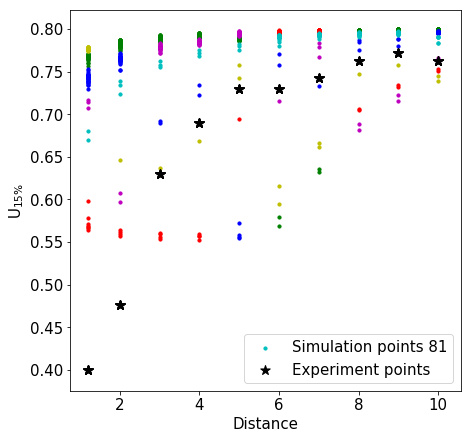

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
fig, ax = plt.subplots(figsize=(7,7))
for index,value in enumerate(d):
    data_set=Train[['d','vel_15']][Train['d'] == value].values
    cluster_num = 6
    kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
    clusters = kmeans.labels_
    centroids = np.array([[value,exp_data['exp_15_vel'][index]]])
    colors = ['r', 'g', 'b', 'y', 'm','c']
    for cluster_index in range(cluster_num) :
        sub_set = np.array([data_set[i] for i in range(len(data_set)) if clusters[i] == cluster_index])
        plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
        plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k')
plt.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index],label='Simulation points 81')
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = 'k',label='Experiment points')
plt.legend(loc='best',fontsize=15)
plt.xlabel('Distance', fontsize=15)
plt.ylabel(r'U$_{15\%}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./U15.png',format='png')
#plt.savefig('./TI03聚类.png',format='png')
plt.show()

In [45]:
data_set=Train[['d','vel_15']][Train['d'] == 1.2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df31 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
#df31

In [46]:
data_set=Train[['d','vel_15']][Train['d'] == 2].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df32 = pd.DataFrame(data_set[[ x==0 for x in kmeans.labels_]])
#df32

In [47]:
data_set=Train[['d','vel_15']][Train['d'] == 3].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df33 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
#df33

In [48]:
data_set=Train[['d','vel_15']][Train['d'] == 4].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df34 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
#df34

In [49]:
data_set=Train[['d','vel_15']][Train['d'] == 5].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df35 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
#df35

In [50]:
data_set=Train[['d','vel_15']][Train['d'] == 6].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df36 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df36

,0,1
0,6.0,0.715588


In [51]:
data_set=Train[['d','vel_15']][Train['d'] == 7].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df37 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df37

,0,1
0,7.0,0.732849


In [52]:
data_set=Train[['d','vel_15']][Train['d'] == 8].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df38 = pd.DataFrame(data_set[[ x==3 for x in kmeans.labels_]])
df38

,0,1
0,8.0,0.746758


In [53]:
data_set=Train[['d','vel_15']][Train['d'] == 8].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df38 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df38

,0,1
0,8.0,0.784349
1,8.0,0.774847
2,8.0,0.786621


In [54]:
data_set=Train[['d','vel_15']][Train['d'] == 9].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df39 = pd.DataFrame(data_set[[ x==2 for x in kmeans.labels_]])
df39

,0,1
0,9.0,0.787821
1,9.0,0.780168
2,9.0,0.788663


In [55]:
data_set=Train[['d','vel_15']][Train['d'] == 10].values
kmeans = KMeans(cluster_num,random_state=42).fit(data_set)
df40 = pd.DataFrame(data_set[[ x==4 for x in kmeans.labels_]])
df40

,0,1
0,10.0,0.766391


In [ ]:
fig,ax = plt.subplots(2, 2,figsize=(15,10))
plt.style.use("seaborn")

#ax[0, 0].plot(d, sim_data_3['sim_03_TI_3'],'o-',c = "#8A2BE2",label='simulation points 83')
ax[0, 0].plot(d, sim_data_1['sim_03_TI_1'],'o-',c = "#000080",label='Simulation points 81')
ax[0, 0].plot(d, sim_data_2['sim_03_TI_2'],'o-',c = "blue",label='Simulation points 82')
ax[0, 0].plot(d, exp_data['exp_03_TI'],'o',c = 'red',label='Experiment points')

#ax[0, 1].plot(d, sim_data_3['sim_03_TI_3'],'o-',c = "#8A2BE2",label='simulation points 83')
ax[0, 1].plot(d, sim_data_1['sim_15_TI_1'],'o-',c = "#000080",label='Simulation points 81')
ax[0, 1].plot(d, sim_data_2['sim_15_TI_2'],'o-',c = "blue",label='Simulation points 82')
ax[0, 1].plot(d, exp_data['exp_15_TI'],'o',c = 'red',label='Experiment points')

#ax[1, 0].plot(d, sim_data_3['sim_03_vel_3'],'o-',c = "#8A2BE2",label='simulation points 83')
ax[1, 0].plot(d, sim_data_1['sim_03_vel_1'],'o-',c = "#000080",label='Simulation points 81')
ax[1, 0].plot(d, sim_data_2['sim_03_vel_2'],'o-',c = "blue",label='Simulation points 82')
ax[1, 0].plot(d, exp_data['exp_03_vel'],'o',c = 'red',label='Experiment points')

#ax[1, 1].plot(d, sim_data_3['sim_15_vel_3'],'o-',c = "#8A2BE2",label='simulation points 83')
ax[1, 1].plot(d, sim_data_1['sim_15_vel_1'],'o-',c = "#000080",label='Simulation points 81')
ax[1, 1].plot(d, sim_data_2['sim_15_vel_2'],'o-',c = "blue",label='Simulation points 82')
ax[1, 1].plot(d, exp_data['exp_15_vel'],'o',c = 'red',label='Experiment points')


ax[0, 0].set_xticks([1.2,2,3,4,5,6,7,8,9,10])
ax[0, 0].legend(loc='best',fontsize=13)
ax[0, 0].set_xlabel('Distance', fontsize=15)
ax[0, 0].set_ylabel(r'I$_{3\%}$',fontsize=15)
ax[0, 1].set_xticks([1.2,2,3,4,5,6,7,8,9,10])
ax[0, 1].legend(loc='best',fontsize=13)
ax[0, 1].set_xlabel('Distance', fontsize=15)
ax[0, 1].set_ylabel(r'I$_{15\%}$', fontsize=15)
ax[1, 0].legend(loc='best',fontsize=13)
ax[1, 0].set_xlabel('Distance', fontsize=15)
ax[1, 0].set_ylabel(r'U$_{3\%}$', fontsize=15)
ax[1, 0].set_xticks([1.2,2,3,4,5,6,7,8,9,10])
ax[1, 1].legend(loc='best',fontsize=13)
ax[1, 1].set_xlabel('Distance', fontsize=15)
ax[1, 1].set_ylabel(r'U$_{15\%}$', fontsize=15)
ax[1, 1].set_xticks([1.2,2,3,4,5,6,7,8,9,10])

plt.savefig('picGA.jpg')
plt.show()

In [56]:
data_vel15 = pd.concat([df31, df32, df33, df34, df35, df36, df37, df38, df39, df40 ], ignore_index=True)
Train_cluster_vel15 = Train[Train['vel_15'].isin(data_vel15[1].values)].reset_index()
Train_cluster_vel15

,index,d,beta_p,beta_d,c_eps4,c_eps5,TI_03,TI_15,vel_03,vel_15
0,240,1.2,0.10,4.00,1.00,0.1,0.019340,0.129755,0.493690,0.577766
1,243,4.0,0.10,4.00,1.00,0.1,0.008599,0.146747,0.474998,0.734635
2,244,5.0,0.10,4.00,1.00,0.1,0.007486,0.141643,0.473350,0.757983
3,247,8.0,0.10,4.00,1.00,0.1,0.005638,0.133167,0.470709,0.784349
4,248,9.0,0.10,4.00,1.00,0.1,0.005262,0.131449,0.470067,0.787821
5,420,1.2,0.55,2.05,1.00,0.1,0.075328,0.150418,0.489799,0.566251
6,421,2.0,0.55,2.05,1.00,0.1,0.053955,0.114698,0.477680,0.558849
7,480,1.2,0.55,4.00,0.55,0.1,0.114946,0.251600,0.783778,0.597705
8,483,4.0,0.55,4.00,0.55,0.1,0.095813,0.166483,0.797696,0.722224
9,484,5.0,0.55,4.00,0.55,0.1,0.094380,0.154222,0.798986,0.742860


In [57]:
Train = pd.concat([Train_cluster_TI03, Train_cluster_TI15, Train_cluster_vel03, Train_cluster_vel15], ignore_index=True).drop(['index'],axis=1)
Train

,d,beta_p,beta_d,c_eps4,c_eps5,TI_03,TI_15,vel_03,vel_15
0,1.2,0.10,0.10,1.00,0.10,0.251953,0.189052,0.531672,0.734357
1,4.0,0.10,0.10,1.00,0.10,0.162229,0.155305,0.657187,0.783726
2,1.2,0.10,0.10,1.00,2.05,0.228103,0.187333,0.592851,0.736880
3,4.0,0.10,0.10,1.00,2.05,0.150299,0.155016,0.702466,0.784223
4,1.2,0.10,0.10,1.00,4.00,0.199546,0.185970,0.641425,0.738858
5,2.0,0.10,0.10,1.00,4.00,0.170509,0.170330,0.686566,0.763898
6,3.0,0.10,0.10,1.00,4.00,0.148815,0.160437,0.715584,0.777772
7,1.2,0.10,2.05,0.55,0.10,0.190487,0.178998,0.477738,0.716319
8,4.0,0.10,2.05,0.55,0.10,0.151300,0.150030,0.590664,0.780759
9,2.0,0.10,4.00,0.10,0.10,0.166521,0.158708,0.608522,0.751547


In [23]:
TrainY_4 = Train[['TI_03','TI_15','vel_03','vel_15']][0:int(len(Train))]
#print(TrainY_4)
TrainX_5 = Train[['d','beta_p','beta_d','c_eps4','c_eps5']][0:int(len(Train))]
#print(TrainX_5)

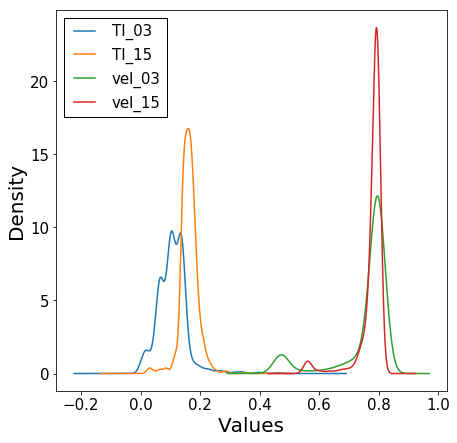

In [24]:
TrainY_4.plot(kind = 'kde', figsize = (7, 7))
plt.style.use("classic")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.xlabel('Values', fontsize=20)
plt.ylabel('Density', fontsize=20)

#plt.savefig('./U15.png',format='png')
plt.savefig('./BG.png',format='png')
# TrainY.show()

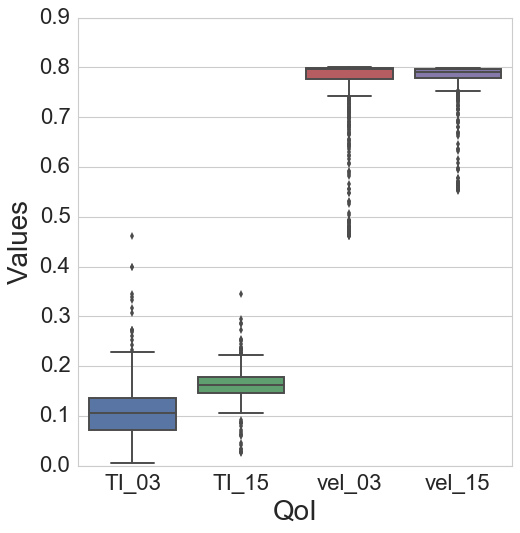

In [35]:
plt.figure(figsize=(7,7))
sns.set(style="whitegrid")
sns.boxplot(data=TrainY_4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('QoI', fontsize=25)
plt.ylabel('Values', fontsize=25)
plt.savefig('./BO.png',format='png')
# plt.title(u"Box plot of the Dataset")

In [61]:
TrainY_4.describe()

,TI_03,TI_15,vel_03,vel_15
count,360.000000,360.000000,360.000000,360.000000
mean,0.107613,0.157624,0.715497,0.761396
std,0.060859,0.040339,0.126263,0.071655
min,0.004953,0.025307,0.464133,0.552166
25%,0.060614,0.138859,0.678732,0.779657
50%,0.118983,0.160149,0.796808,0.792901
75%,0.137633,0.178170,0.799660,0.796037
max,0.462270,0.345609,0.800220,0.799569


In [6]:
# Outlier detection 
import pandas as pd
import numpy as np
from collections import Counter

def detect_outliers(df,n,features):#n表示每個樣本所允許的離群值個數

    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)#輸出25%四分位點
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)兩個四分位點中間區域
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices) 
    #print (outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

In [7]:
Outliers_to_drop = detect_outliers(TrainY_4,0,["TI_03","TI_15","vel_03","vel_15"])
TrainY_4 = TrainY_4.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
TrainX_5 = TrainX_5.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
Train_new = Train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

NameError: name 'TrainY_4' is not defined

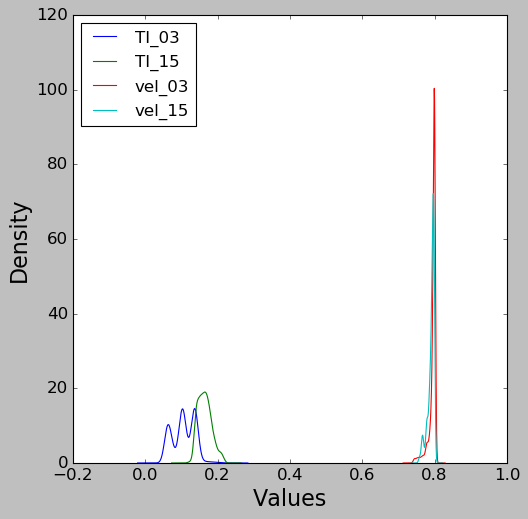

In [64]:
TrainY_4.plot(kind = 'kde', figsize = (7, 7))
plt.style.use("classic")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.xlabel('Values', fontsize=20)
plt.ylabel('Density', fontsize=20)

#plt.savefig('./U15.png',format='png')
plt.savefig('./AG.png',format='png')
# TrainY.show()

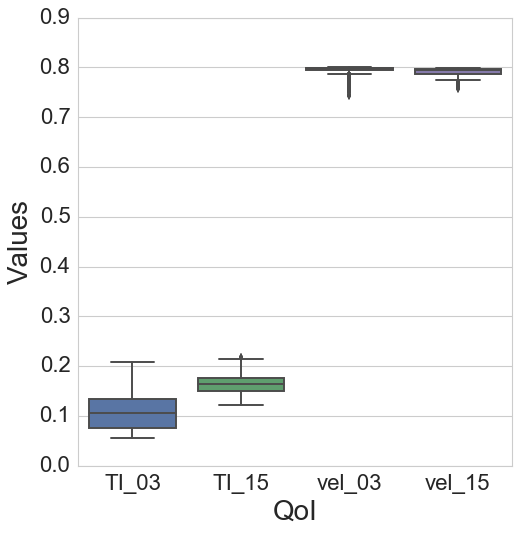

In [66]:
plt.figure(figsize=(7,7))
sns.set(style="whitegrid")
sns.boxplot(data=TrainY_4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('QoI', fontsize=25)
plt.ylabel('Values', fontsize=25)
plt.savefig('./AO.png',format='png')
# plt.title(u"Box plot of the Dataset")

In [66]:
TrainY_4.describe()

,TI_03,TI_15,vel_03,vel_15
count,268.000000,268.000000,268.000000,268.000000
mean,0.114221,0.162772,0.774065,0.792649
std,0.038396,0.022426,0.055605,0.006629
min,0.055204,0.121104,0.503377,0.757784
25%,0.067486,0.140217,0.787583,0.790785
50%,0.129152,0.165788,0.798700,0.794719
75%,0.137948,0.178218,0.799767,0.796509
max,0.232883,0.218227,0.800220,0.799569


# 加入Bootstrap

In [65]:
train_array=Train_new.values
print(train_array)

[[ 4.          0.1         0.1        ...  0.15530471  0.657187
   0.783726  ]
 [ 4.          0.1         0.1        ...  0.15501585  0.702466
   0.784223  ]
 [ 2.          0.1         0.1        ...  0.1703301   0.686566
   0.763898  ]
 ...
 [ 8.          1.          0.1        ...  0.17088909  0.712094
   0.786621  ]
 [ 9.          1.          0.1        ...  0.16460624  0.718122
   0.788663  ]
 [10.          1.          4.         ...  0.12110408  0.800011
   0.766391  ]]


In [66]:
random.seed(a=42, version=2)
train_total_bootstrap=[]
for i in range (1000):
    train_total_bootstrap.append(random.choice(train_array))

# 訓練集數據

In [67]:
train_total_new = pd.DataFrame(train_total_bootstrap)
train_total_new.columns =['d','beta_p','beta_d','c_eps4','c_eps5','TI_03','TI_15','vel_03','vel_15']
train_total_new.head(10)
#print(train_total_new.shape)

,d,beta_p,beta_d,c_eps4,c_eps5,TI_03,TI_15,vel_03,vel_15
0,2.0,1.00,2.05,0.55,0.10,0.139574,0.205294,0.798354,0.779807
1,9.0,0.55,0.10,1.00,2.05,0.131215,0.157915,0.753553,0.796194
2,10.0,0.10,2.05,0.10,2.05,0.057999,0.137634,0.799124,0.796749
3,9.0,0.10,0.10,1.00,0.10,0.107548,0.142207,0.715540,0.795456
4,10.0,0.10,0.10,0.10,4.00,0.061061,0.141082,0.799440,0.797043
5,2.0,1.00,2.05,1.00,4.00,0.139200,0.199855,0.797729,0.785098
6,3.0,1.00,2.05,0.10,2.05,0.138077,0.188120,0.799571,0.791783
7,7.0,1.00,0.10,1.00,2.05,0.167902,0.179645,0.750807,0.792119
8,8.0,0.55,4.00,0.55,0.10,0.092844,0.135795,0.800069,0.774847
9,9.0,0.55,0.10,1.00,4.00,0.128040,0.158386,0.776641,0.796848


In [68]:
TrainX_5 = train_total_new[['d','beta_p','beta_d','c_eps4','c_eps5']][0:int(len(train_total_new))]
TrainY_4 = train_total_new[['TI_03','TI_15','vel_03','vel_15']][0:int(len(train_total_new))]
#print(TrainX_5)
#print(TrainY_4)

# 測試集數據

In [69]:
TestX_5 = Test[['d','beta_p','beta_d','c_eps4','c_eps5']][0:int(len(Test))]
TestY_4 = Test[['TI_03','TI_15','vel_03','vel_15']][0:int(len(Test))]
# print(TestX_5)
# print(TestY_4)

In [70]:
X_test = np.array(TestX_5)
#X_test = np.log10(np.array(TestX_5))
#print (X_test)
#print (np.shape(X_test))
y_test= np.array(TestY_4)
#y_test= np.log10(np.array(TestY_4))
#y_test=y_test1[:,3]
#print (y_test)
#print (np.shape(y_test))
TestY_4.describe()
TestY_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 4 columns):
TI_03     160 non-null float64
TI_15     160 non-null float64
vel_03    160 non-null float64
vel_15    160 non-null float64
dtypes: float64(4)
memory usage: 5.1 KB


In [71]:
X_train = np.array(TrainX_5)
y_train = np.array(TrainY_4)

In [72]:
#TI_03
GPmodel = GridSearchCV(gpr(normalize_y=True), cv=5,
                    param_grid={"alpha": np.logspace(-4, 4, 10)})
GPmodel = GPmodel.fit(X_train, y_train[:,0])
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print(GPmodel.best_params_)

Best Gaussian Process model
{'alpha': 0.0001}


In [73]:
#TI_15
GPmodel = GridSearchCV(gpr(normalize_y=True), cv=5,
                       param_grid={"alpha": np.logspace(-5, 5, 10)})
GPmodel = GPmodel.fit(X_train, y_train[:,1])
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print(GPmodel.best_params_)

Best Gaussian Process model
{'alpha': 1e-05}


In [74]:
#vel_03
GPmodel = GridSearchCV(gpr(normalize_y=True), cv=5,
                       param_grid={"alpha": np.logspace(-5, 5, 10)})
GPmodel = GPmodel.fit(X_train, y_train[:,2])
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print(GPmodel.best_params_)

Best Gaussian Process model
{'alpha': 1e-05}


In [75]:
#vel_15
GPmodel = GridSearchCV(gpr(normalize_y=True), cv=5,
                       param_grid={"alpha": np.logspace(-5, 5, 10)})
GPmodel = GPmodel.fit(X_train, y_train[:,3])
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print(GPmodel.best_params_)

Best Gaussian Process model
{'alpha': 1e-05}


# 高斯模型的選擇

In [76]:
ker_expsine = ConstantKernel() * ExpSineSquared()
print (ker_expsine)
ker_dot = ConstantKernel() * DotProduct()
print (ker_dot)
ker_rbf = ConstantKernel() * RBF()
#print (ConstantKernel)#ConstantKernel和RBF都是高斯模型的核函數（協方差函數）
print (ker_rbf)#1**2 * RBF(length_scale=1)
ker_rq = ConstantKernel() * RationalQuadratic()
print (ker_rq)
ker_matern = ConstantKernel() * Matern()
print (ker_matern)
kernel_list = [ker_expsine,ker_dot,ker_rbf,ker_rq,ker_matern]#ker_expsine]#,ker_dot,ker_rbf,ker_rq,ker_matern]
print (kernel_list)

1**2 * ExpSineSquared(length_scale=1, periodicity=1)
1**2 * DotProduct(sigma_0=1)
1**2 * RBF(length_scale=1)
1**2 * RationalQuadratic(alpha=1, length_scale=1)
1**2 * Matern(length_scale=1, nu=1.5)
[1**2 * RationalQuadratic(alpha=1, length_scale=1), 1**2 * Matern(length_scale=1, nu=1.5)]


### 求預測值與實驗值的誤差

In [77]:
def train_perofrmace (Y, X):
    mape_list = [0]*4 
    for index ,key in enumerate (['TI_03',"TI_15",'vel_03',"vel_15"]):#mape的順序,每一個直行都是一個TI_03在RBF
        model = model_list[key]
        mape_list[index] = my_custom_score_func(Y[:,index], model.predict(X))#Y[:,index]是超级电脑的实验值，model.predict(X)是预测值
        #print(Y[:,index])
        #print(Y[:,index].shape)#一直都是162
    return mape_list

### K-fold

In [78]:
seed = 42
np.random.seed(seed)
print (np.random.seed(seed))
kfold = KFold(n_splits=5, shuffle=True,random_state=seed)

None


初始核函數： 1**2 * RationalQuadratic(alpha=1, length_scale=1)
訓練集每一折4個預測值的MAPE值
 [3.8169647460889538, 0.5009422495085714, 0.09274228862325257, 0.042271430600030316]
上面列表的4個值求平均: 1.113230


訓練集每一折4個預測值的MAPE值
 [3.2130670406337587, 0.6052409277155149, 0.0969975333447706, 0.08050529338236066]
上面列表的4個值求平均: 0.998953


訓練集每一折4個預測值的MAPE值
 [2.709271643143059, 0.522973581236289, 0.06837154622011907, 0.056777166587826125]
上面列表的4個值求平均: 0.839348


訓練集每一折4個預測值的MAPE值
 [3.579073849120213, 0.7148887349970701, 0.0796085004863833, 0.05565717256396316]
上面列表的4個值求平均: 1.107307


訓練集每一折4個預測值的MAPE值
 [3.933316251049259, 0.7343825056060769, 0.2620554074656172, 0.0790760753483582]
上面列表的4個值求平均: 1.252208


5個平均值再求平均:1.062209 (標準差:+/- 0.137408)


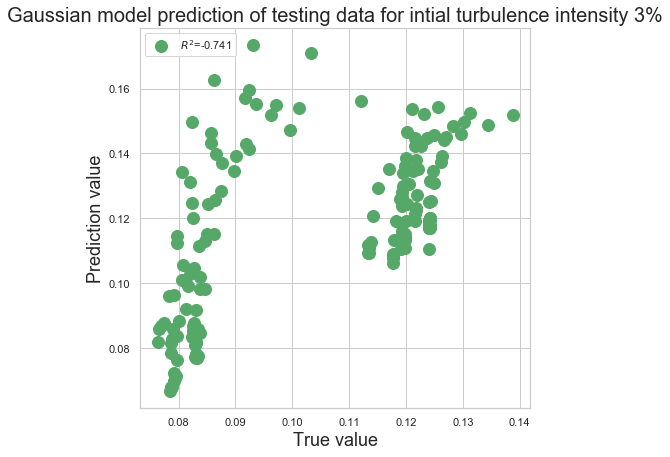

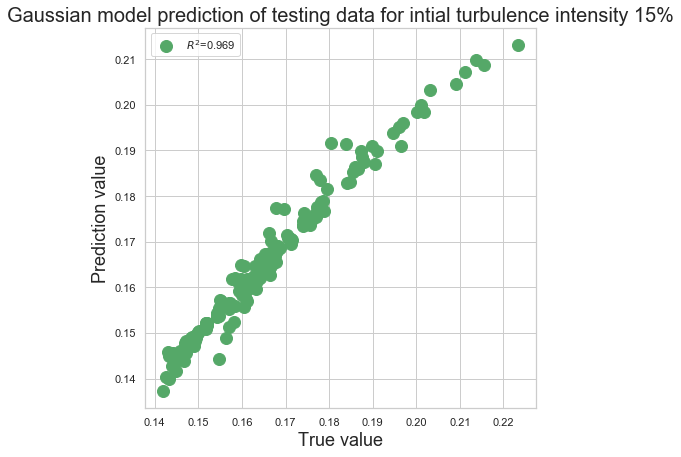

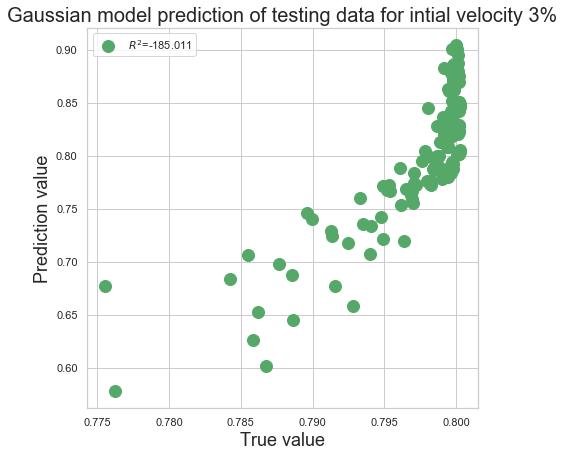

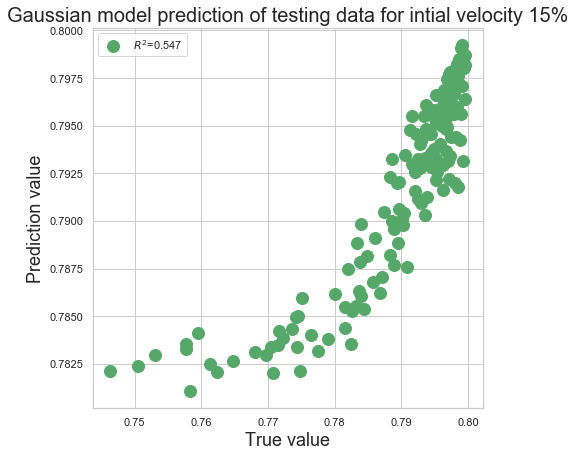

初始核函數： 1**2 * Matern(length_scale=1, nu=1.5)
訓練集每一折4個預測值的MAPE值
 [3.4528755306562955, 0.3183496282305567, 0.22943758864049038, 0.04710224472866872]
上面列表的4個值求平均: 1.011941


訓練集每一折4個預測值的MAPE值
 [2.892088618305015, 0.4754662629664017, 0.1335461913368609, 0.08954227520081919]
上面列表的4個值求平均: 0.897661


訓練集每一折4個預測值的MAPE值
 [2.3261990014178933, 0.364044306814492, 0.038704346022216334, 0.06462733412320648]
上面列表的4個值求平均: 0.698394


訓練集每一折4個預測值的MAPE值
 [3.156366414564559, 0.5209276524216788, 0.09651616113867706, 0.06476837564867546]
上面列表的4個值求平均: 0.959645


訓練集每一折4個預測值的MAPE值
 [3.4666088556531474, 0.4861674449007972, 0.3558390713798227, 0.08903080488544678]
上面列表的4個值求平均: 1.099412


5個平均值再求平均:0.997810 (標準差:+/- 0.150599)


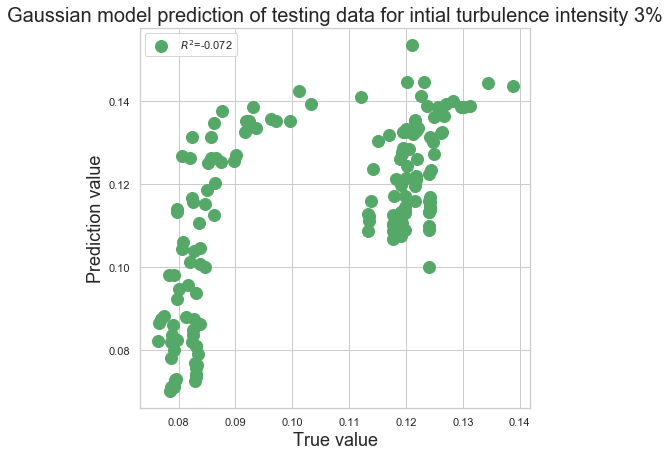

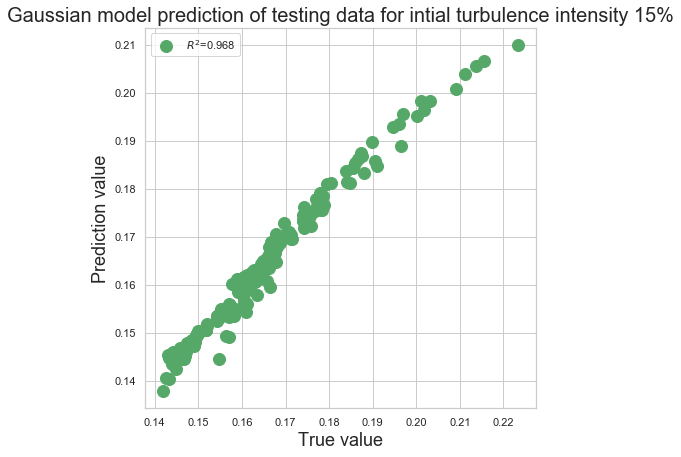

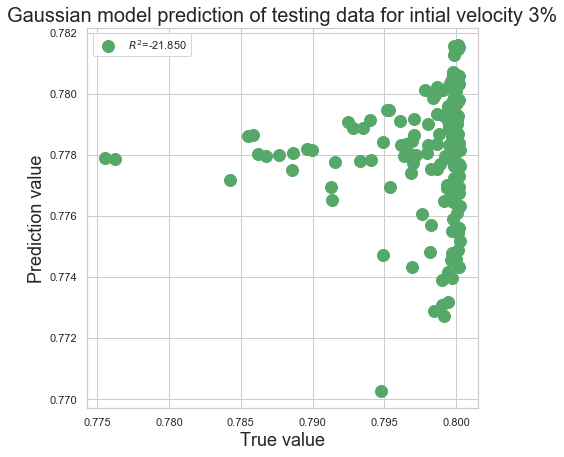

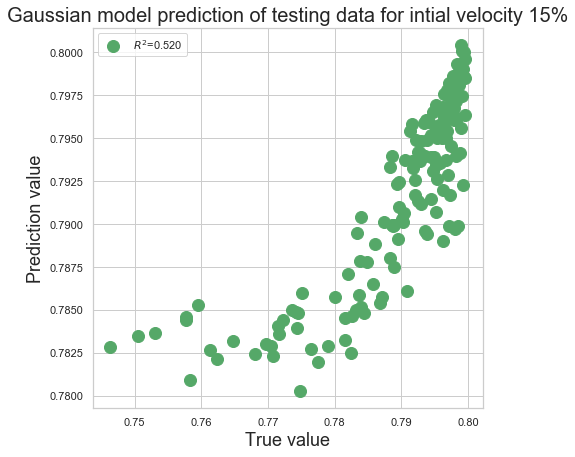

,Turbulence intensity 3%,Turbulence intensity 15%,Velocity 3%,Velocity 15%
"1**2 * RationalQuadratic(alpha=1, length_scale=1) R2",-0.740962,0.969420,-185.010538,0.546816
"1**2 * RationalQuadratic(alpha=1, length_scale=1) MAPE",18.796136,1.155822,5.610840,0.529668
"1**2 * RationalQuadratic(alpha=1, length_scale=1) MSE",0.000662,0.000009,0.003302,0.000059
"1**2 * RationalQuadratic(alpha=1, length_scale=1) MAE",0.017882,0.001947,0.044650,0.004094
"1**2 * Matern(length_scale=1, nu=1.5) R2",-0.071893,0.968003,-21.850363,0.520366
"1**2 * Matern(length_scale=1, nu=1.5) MAPE",15.884270,1.157196,2.464110,0.550636
"1**2 * Matern(length_scale=1, nu=1.5) MSE",0.000408,0.000009,0.000406,0.000062
"1**2 * Matern(length_scale=1, nu=1.5) MAE",0.015008,0.001988,0.019678,0.004259


In [79]:
string= ['intial turbulence intensity 3%','intial turbulence intensity 15%','intial velocity 3%', 'intial velocity 15%']
mean_scores = []
data_total=pd.DataFrame()
for index, k in enumerate(kernel_list):
    print("初始核函數：",k)
    for train, validation in kfold.split(X_train, y_train):
        #split(X, y=None, groups=None)：將training data劃分成train和validation
        #宣告模型設定
        model_TI_03 = gpr(kernel=k,alpha = 0.0001,n_restarts_optimizer=5,
                          normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=42);
        model_TI_15 = gpr(kernel=k,alpha = 1e-05,n_restarts_optimizer=5,
                          normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=42);        
        model_vel_03 = gpr(kernel=k,alpha = 1e-05,n_restarts_optimizer=5,
                           normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=42);
        model_vel_15 = gpr(kernel=k,alpha = 1e-05,n_restarts_optimizer=5,
                           normalize_y="True",optimizer='fmin_l_bfgs_b',random_state=42);

        model_TI_03.fit(X_train[train],y_train[:,0][train])#fit返回值是162個高斯回归模型的预测值组成的列表
        model_TI_15.fit(X_train[train],y_train[:,1][train])
        model_vel_03.fit(X_train[train],y_train[:,2][train])
        model_vel_15.fit(X_train[train],y_train[:,3][train])
        #print (model_TI_03.fit(X_data[train],Y_data[:,0][train]))
        #fit （X，y）	擬合高斯過程回歸模型。X ：類似數組，shape =（n_samples，n_features）培訓數據
        #y ：類似數組，shape =（n_samples，[n_output_dims]）目標值

        model_list = {'TI_03':model_TI_03,'TI_15':model_TI_15,'vel_03':model_vel_03,'vel_15':model_vel_15}
        
        # evaluate the model
        scores = train_perofrmace(y_train[validation],X_train[validation])#输出mape_list,即四个平均误差值组成的列表
        print('訓練集每一折4個預測值的MAPE值\n',scores)
        print("%s: %f" % ('上面列表的4個值求平均', np.mean(scores)))
        print ('\n')
        mean_scores.append(np.mean(scores))
    print("%s:%f (%s:+/- %f)" % ('5個平均值再求平均',np.mean(mean_scores), '標準差',np.std(mean_scores))) # np.std计算全局标准差和相同的剩餘值組成的list 
    
    #測試集分析
    model_total=[model_TI_03,model_TI_15,model_vel_03,model_vel_15]
    R2=[]
    MAPE=[]
    MSE=[]
    MAE=[]
    for i, model in enumerate(model_total):
        
        #畫測試集的圖
        plt.figure(figsize=(7,7), facecolor='w')
        plt.plot(y_test[:,i], model.predict(X_test), 'go', markersize = 12, zorder=2, label=u'$R^2$=%.3f' % model.score(X_test, y_test[:,i]))
        plt.legend(loc = 'upper left')
        plt.xlabel(u'True value', fontsize=18)
        plt.ylabel(u'Prediction value', fontsize=18)
        plt.title(u'Gaussian model prediction of testing data for %s' % string[i], fontsize=20)
        
        #輸出測試集的評價參數
        R2.append(model.score(X_test, y_test[:,i]))
        MAPE.append(my_custom_score_func(y_test[:,i], model.predict(X_test)))
        MSE.append(mean_squared_error(y_test[:,i], model.predict(X_test)))
        MAE.append(mean_absolute_error(y_test[:,i], model.predict(X_test)))
    a=np.vstack((np.array(R2),np.array(MAPE),np.array(MSE),np.array(MAE)))#所有的array并列起来
    data1 = pd.DataFrame(a, index=['%s R2'% kernel_list[index],'%s MAPE'% kernel_list[index], '%s MSE' % kernel_list[index],
                               '%s  MAE'% kernel_list[index]], columns=['Turbulence intensity 3%','Turbulence intensity 15%','Velocity 3%','Velocity 15%'])  
    data_total=pd.concat([data_total,data1])

#     print ("TI_03優化後的核函数：",model_TI_03.kernel_)
#     print ("TI_15優化後的核函数：",model_TI_15.kernel_)
#     print ("vel_03優化後的核函数：",model_vel_03.kernel_)
#     print ("vel_15優化後的核函数：",model_vel_15.kernel_)
    plt.show()
data_total

In [80]:
d = [1.2, 2 , 3, 4, 5, 6, 7, 8, 9, 10 ]
exp =['exp_03_TI','exp_03_vel','exp_15_TI','exp_15_vel']
model=[model_TI_03,model_vel_03,model_TI_15,model_vel_15]
exp_data = {
             'exp_03_TI'  : [  0.219, 0.168, 0.139, 0.176, 0.197, 0.191, 0.16 , 0.146, 0.129, 0.122  ],
             'exp_03_vel' : [  0.402, 0.403, 0.396, 0.387, 0.402, 0.445, 0.494, 0.548, 0.569, 0.610  ],
             'exp_15_TI'  : [  0.321, 0.286, 0.217, 0.192, 0.170, 0.170, 0.137, 0.136, 0.134, 0.138  ],
             'exp_15_vel' : [  0.400, 0.476, 0.630, 0.690, 0.729, 0.730, 0.742, 0.762, 0.772, 0.763  ]
}

# minimized predict error

In [81]:
def black_box_function(x):
    error=0
    for i in d:
        for index, value in enumerate(exp):
            Input_data=np.array([[i,x[0],x[1],x[2],x[3]]])
            f=(np.abs(exp_data[value][int(i)-1] - model[index].predict(Input_data))/exp_data[value][int(i)-1])*100
            #print (f)
            error=error+f
    return float(error/40)

# GA演算法

-------------------- SGA config is: --------------------
lower_bound:[0.1, 0.1, 0.1, 0.1]
upper_bound:[1, 4, 1, 4]
variables_num:4
func:<function black_box_function at 0x000001DDEFA32E18>
cross_rate:0.7
mutation_rate:0.1
population_size:100
generations:1000
binary_code_length:10
func_type:min
-------------------- SGA caculation result is: --------------------
global best generation index/total generations:894/1000
global best point:[0.71583578 0.10381232 0.9973607  0.17624633]
global best target:27.88282755450903


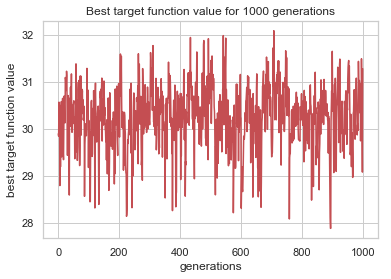

In [82]:
from sopt.SGA import SGA
from math import sin

if __name__ == '__main__':
    sga = SGA.SGA(func = black_box_function,func_type = 'min',variables_num = 4,
        lower_bound = [0.1,0.1,0.1,0.1],upper_bound = [1,4,1,4],generations = 1000,
        binary_code_length = 10)
    
    # run SGA
    sga.run()
    # show the SGA optimization result in figure
    sga.save_plot()
    # print the result
    sga.show_result()

# PSO演算法

In [83]:
from pyswarm import pso

In [84]:
xopt, fopt = pso(func=black_box_function, lb=(0.1,0.1,0.1,0.1), ub=(1,4,1,4),debug=True)
print("誤差：{} {}".format(fopt, xopt))

No constraints given.
New best for swarm at iteration 1: [0.12578142 0.1        1.         0.1       ] 30.512960837374408
New best for swarm at iteration 1: [0.63470017 1.60708059 0.89715599 0.1       ] 30.4087504854747
Best after iteration 1: [0.63470017 1.60708059 0.89715599 0.1       ] 30.4087504854747
New best for swarm at iteration 2: [0.15026222 0.1        1.         0.1       ] 30.350821220201663
New best for swarm at iteration 2: [1.         0.1        0.82121451 0.67166604] 30.333683359535637
New best for swarm at iteration 2: [0.6027217  1.67897581 1.         0.1       ] 29.977182506584864
New best for swarm at iteration 2: [0.37485509 0.1        0.94429466 0.1       ] 29.667824991710336
Best after iteration 2: [0.37485509 0.1        0.94429466 0.1       ] 29.667824991710336
New best for swarm at iteration 3: [0.60155589 0.1        1.         0.1       ] 27.936643668569438
Best after iteration 3: [0.60155589 0.1        1.         0.1       ] 27.936643668569438
New best for sw

# 畫Surrogate Model和物理實驗的對照圖

In [85]:
def plot(x):
    d = [1.2, 2 , 3, 4, 5, 6, 7, 8, 9, 10 ]
    f, axarr = plt.subplots(2,2,figsize=(10,7))
    predictionlist=[]
    for index, value in enumerate(exp):   
        for i in d:
            Input_data=np.array([[i,x[0],x[1],x[2],x[3]]])
            prediction=model[index].predict(Input_data)
            predictionlist.append(prediction)
    #print (predictionlist)
    axarr[0, 0].plot(d, exp_data['exp_03_TI'],'o',c = 'red',label='exp points')
    axarr[0, 0].plot(d, predictionlist[:10] ,c = 'b',label='predict line')
    axarr[0, 0].legend(loc='best')
    axarr[0, 0].set_title('TI_03')
    axarr[0, 1].plot(d, exp_data['exp_03_vel'],'o',c = 'red',label='exp points')
    axarr[0, 1].plot(d, predictionlist[10:20] ,c = 'b',label='predict line')
    axarr[0, 1].legend(loc='best') 
    axarr[0, 1].set_title('vel_03')
    axarr[1, 0].plot(d, exp_data['exp_15_TI'],'o',c = 'red',label='exp points')
    axarr[1, 0].plot(d, predictionlist[20:30] ,c = 'b',label='predict line')
    axarr[1, 0].legend(loc='best')
    axarr[1, 0].set_title('TI_15')
    axarr[1, 1].plot(d, exp_data['exp_15_vel'],'o',c = 'red',label='exp points')
    axarr[1, 1].plot(d, predictionlist[30:40] ,c = 'b',label='predict line')
    axarr[1, 1].legend(loc='best')
    axarr[1, 1].set_title('vel_15')
    return f.tight_layout()

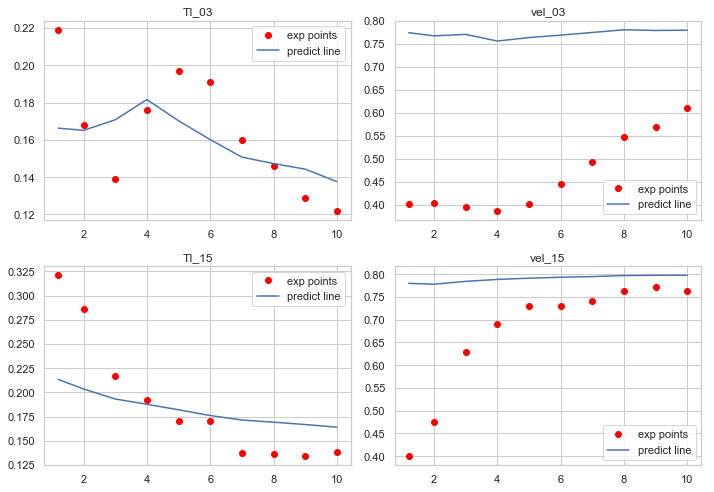

In [86]:
plot([0.7819, 0.1, 1, 4])

In [87]:
#plot([0.82022098, 0.1   ,   1.    ,     2.10381478])

# Simulation和Surragate的比較(Mape)

In [88]:
#Gassian and PSO
d = [1.2, 2 , 3, 4, 5, 6, 7, 8, 9, 10 ]
sim =['sim_03_TI','sim_03_vel','sim_15_TI','sim_15_vel']
model=[model_TI_03,model_vel_03,model_TI_15,model_vel_15]
sim_data = {
             'sim_03_TI'  : [  0.3057,0.2520,0.2156,0.1929,0.1767,0.1645,0.1547,0.1466,0.1397,0.1338 ],
             'sim_03_vel' : [ 0.6898,0.7239,0.7451,0.7567,0.7641,0.7692,0.7728,0.7756,0.7778,0.7796],
             'sim_15_TI'  : [ 0.2525,0.2204,0.2007,0.1894,0.1818,0.1763,0.172,0.1686,0.1658,0.1633 ],
             'sim_15_vel' : [ 0.7535,0.7721,0.7824,0.7877,0.791,0.7932,0.7948,0.7961,0.797,0.7977]
}

In [89]:
error=0
for i in d:
    for index, value in enumerate(sim):
        Input_data=np.array([[i, 0.7819, 0.1, 1, 4]])
        f=(np.abs(model[index].predict(Input_data) - sim_data[value][int(i)-1])/ sim_data[value][int(i)-1])*100
        #print (f)
        error=error+f
print(float(error/40))

4.488125280050584
